In [1]:
import finbox
import pandas as pd
import numpy as np

## Backtest With Weight Rebalance Strategy

### Data Prepare

In [2]:
# Download market data from Yahoo API

FROMDATE = '2010-01-01'
TODATE = '2018-01-01'

spy = finbox.data.equity.get_history('SPY', fromdate=FROMDATE,
                                     todate=TODATE, set_index=True)
aapl = finbox.data.equity.get_history('AAPL', fromdate=FROMDATE,
                                      todate=TODATE, set_index=True)
amzn = finbox.data.equity.get_history('AMZN', fromdate=FROMDATE,
                                      todate=TODATE, set_index=True)

spy.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,94.130867,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,94.380074,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,94.446495,116074400


### Generate Simple Weights

Normally buy `AAPL` and `AMZN` half and half, then randomly select some days all-in `AAPL` or `AMZN`

In [3]:
np.random.seed(999)

weights = pd.DataFrame({'AAPL': 0.5, 'AMZN': 0.5}, index=spy.index)
shift_to_aapl = weights.sample(frac=0.05).index
shift_to_amzn = weights.sample(frac=0.05).index
weights.loc[shift_to_aapl, 'AAPL'] = 1
weights.loc[shift_to_aapl, 'AMZN'] = 0
weights.loc[shift_to_amzn, 'AMZN'] = 1
weights.loc[shift_to_amzn, 'AAPL'] = 0

weights.head(3)

,AAPL,AMZN
Date,,
2010-01-04,0.5,0.5
2010-01-05,0.5,0.5
2010-01-06,0.5,0.5


### Backtest with Finbox's Backtest Engine

Once leveraged transaction costs, we noticed the re-balanced portfolio crashed.

We can also set up a report object to visualize its performance with comparable benchmarks.

In [4]:
# Backtest with finbox

strat = finbox.backtest.build_weights_rebalance_strategy(
    tickers=['AAPL', 'AMZN'],
    weights=weights,
    datasets=[aapl, amzn],
    lazy_rebalance=True,
    is_debug=False,
    commission_settings=[{'commission': 0.001}],  # applied 0.1% transaction costs for each trade
    weight_slippage=0.001
)

,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.46,2012-09-19,2013-04-19,2013-10-25,288
1,21.11,2010-04-22,2010-07-02,2010-09-24,112
2,20.88,2015-12-08,2016-02-09,2016-05-31,126
3,20.88,2011-09-19,2011-12-14,2012-03-16,130
4,15.12,2011-07-28,2011-08-22,2011-09-15,36


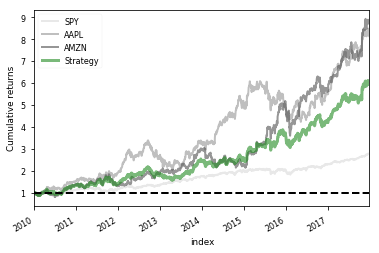

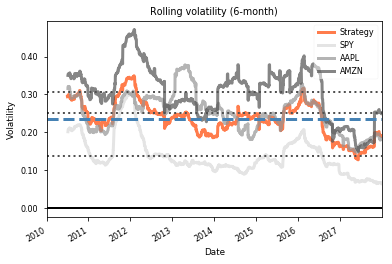

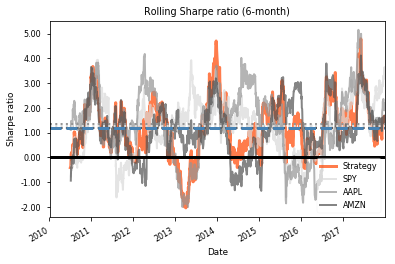

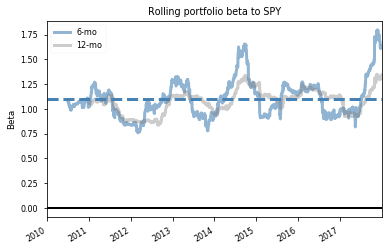

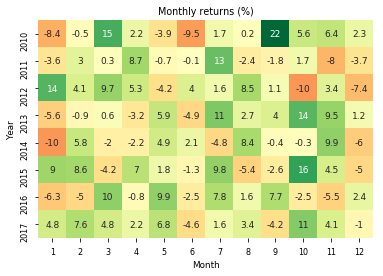

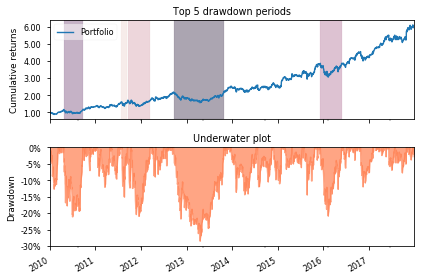

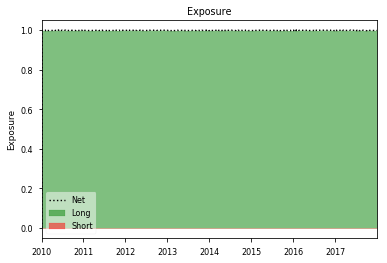

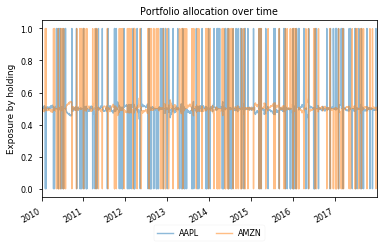

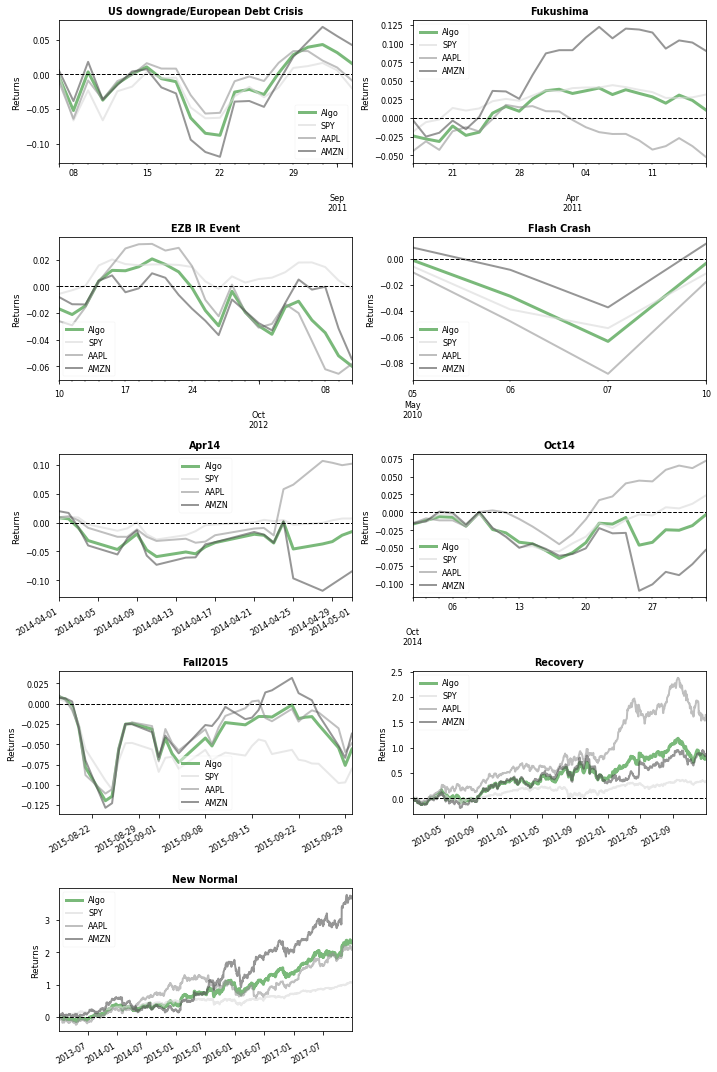

In [5]:
benchmark1 = spy['Adj Close'].pct_change().dropna()
benchmark1.name = 'SPY'

benchmark2 = aapl['Adj Close'].pct_change().dropna()
benchmark2.name = 'AAPL'

benchmark3 = amzn['Adj Close'].pct_change().dropna()
benchmark3.name = 'AMZN'

# Run Report Builder with matplotlib inside jupyter notebook
rb = finbox.backtest.report.ReportBuilder
rb = rb(strat, [benchmark1, benchmark2, benchmark3])
rb.build_report(chart_type='matplotlib')

## Output Backtest Results As HTML reports

View it from modern browser like Chrome

In [6]:
rb.build_report(dest='report_sample.html')